In [24]:
# use geo_env
import numpy as np
import pandas as pd
from pyproj import CRS, Transformer
import xarray as xr
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# SMB data

In this script we preprocess surface mass balance (smb) data from RACMO2.4p1, because this is used in the apparent mass balance term in BedMachine. However, because the smb is so small we refrain from integrating these.

# Dowload the data

In the terminal, use the following command to download the zip folder from zenodo:  
`wget --content-disposition "https://zenodo.org/records/13773130/files/ANT27_RACMO24p1_data.zip?download=1"`

Unzip with:
`unzip ANT27_RACMO24p1_data.zip -d racmo24p1`

Data set:
[Monthly RACMO2.4p1 data for Greenland (11 km) and Antarctica (27 km) for SMB, SEB, near-surface temperature and wind speed (2006-2015)](https://zenodo.org/records/13773130)

Make sure to get Version 2 since Version 1 is missing most months.

In [15]:
path_to_folder = "/home/kim/data/racmo/racmo24p1/ANT27_RACMO24p1_data/"
# NOTE: Stands for smb glaciated
filename = "smbgl_monthlyS_ANT27_RACMO24p1_200601_201512.nc"
full_path = path_to_folder + filename

smb_r24 = xr.open_dataset(full_path)
print(smb_r24.smbgl.values.shape) # rlon: 262 rlat: 240
smb_r24

(120, 1, 240, 262)


<xarray.Dataset> Size: 32MB
Dimensions:       (time: 120, bnds: 2, rlon: 262, rlat: 240, height: 1,
                   nblock1: 40, nblock2: 400)
Coordinates:
  * time          (time) datetime64[ns] 960B 2006-01-16 ... 2015-12-16
  * rlon          (rlon) float64 2kB -32.75 -32.5 -32.25 ... 32.0 32.25 32.5
  * rlat          (rlat) float64 2kB -30.0 -29.75 -29.5 ... 29.25 29.5 29.75
    lon           (rlat, rlon) float64 503kB ...
    lat           (rlat, rlon) float64 503kB ...
  * height        (height) float64 8B 0.0
Dimensions without coordinates: bnds, nblock1, nblock2
Data variables:
    time_bnds     (time, bnds) datetime64[ns] 2kB ...
    rotated_pole  float32 4B ...
    assigned      (time) int32 480B ...
    block1        (nblock1) int32 160B ...
    block2        (nblock2) int32 2kB ...
    date_bnds     (time, bnds) int32 960B ...
    dir           (rlat, rlon) float64 503kB ...
    dtg           (time) int32 480B ...
    hms_bnds      (time, bnds) int32 960B ...
    smbgl         (time, height, rlat, rlon) float32 30MB -0.00293 ... 0.002991
Attributes:
    CDI:           Climate Data Interface version 2.1.0 (https://mpimet.mpg.d...
    Conventions:   CF-1.4
    source:        RACMO2
    institution:   Royal Netherlands Meteorological Institute (KNMI)
    Domain:        ANT27y18
    Experiment:    RACMO24_1_sndrift_all_fix2
    CreationDate:  Fri Sep 15 16:45:57 2023
    comment:       asim2cdf: cpar=smbgl, iwmo=222, ilvt=105, ilev=0, idh=24, ...
    title:         Surface Mass Balance (glaciated)
    NCO:           netCDF Operators version 4.9.7 (Homepage = http://nco.sf.n...
    history:       Tue Sep 17 15:33:28 2024: cdo selyear,2006/2015 smbgl_mont...
    CDO:           Climate Data Operators version 2.1.0 (https://mpimet.mpg.d...

## Notes

- Units: kg / m-2 / month
- Time: 10 years (120 months)

## Tranform projection

We want to do the following transformation:
kg / m^2 / month -> m ice equivalent / yr (average)

RACMO does not use the Antarctic Polar Stereographic projection.

In [16]:
# Source CRS used by RACMO2.4p1 
rotated_crs = CRS.from_proj4(smb_r24.rotated_pole.proj4_params)
# Target CRS (Antarctic Polar Stereographic)
ps_crs = CRS.from_epsg(3031)

# define transformer
rotated_to_polar = Transformer.from_crs(rotated_crs, ps_crs, always_xy = True)

# extracted source grid (rotated)
rlon = smb_r24['rlon'].values
rlat = smb_r24['rlat'].values
rlon2d, rlat2d = np.meshgrid(rlon, rlat)

# uses x, y order so (lon, lat) as INPUT and OUTPUT
x_ps, y_ps = rotated_to_polar.transform(rlon2d, rlat2d)

# assign as extra coordinates
smb_r24 = smb_r24.assign_coords({
    "x_ps": (("x", "y"), x_ps),
    "y_ps": (("x", "y"), y_ps),
})

## Plot continental mean smb

SMB > 0: growth  
SMB < 0: loss  

SMB is dominated by snowfall (input). The interior has minimal snowfall and is thus considered a desert. While individual monthly values are negative, the sum or mean is positive. Sublimation and runoff are small compared to snowfall. 

Apparent mass balance = smb + bmb + dh/dt (thinning).  
Basal mass balance is understood to be very small. Thinning from ice dynmaics is capture in other dataset but can also be disregarded.

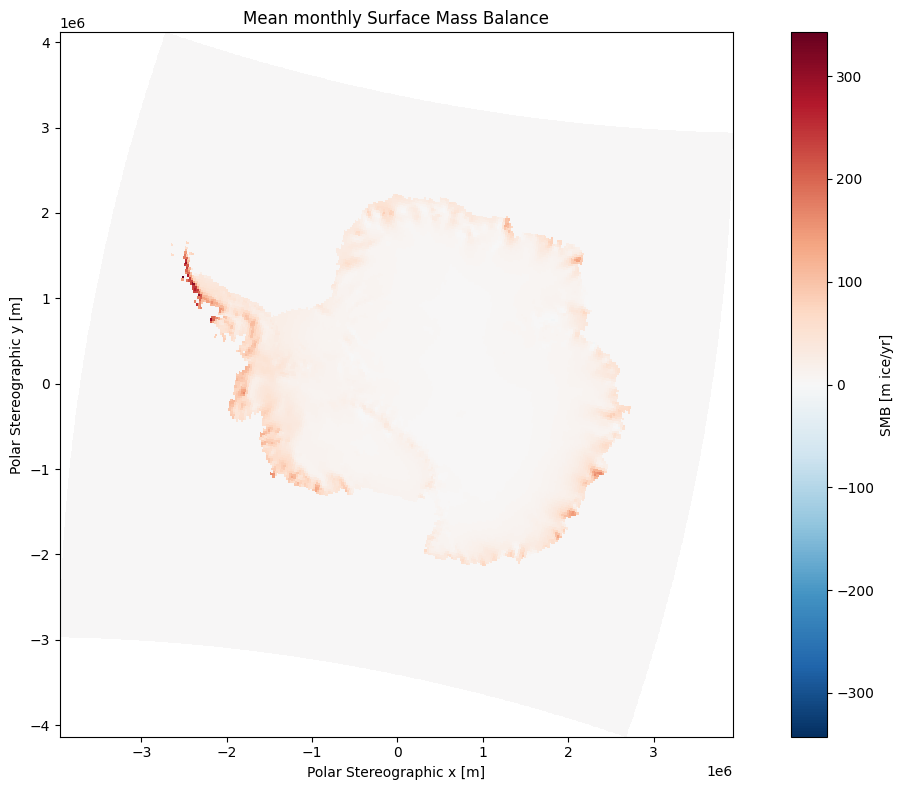

In [17]:
# Some negative values: smb_r24["smbgl"].min()
# Extract the data
smb = smb_r24["smbgl"].mean(axis = 0).squeeze()
# smb = smb_r24["smbgl"][8].squeeze()
x = smb_r24["x_ps"]
y = smb_r24["y_ps"]

# Determine symmetric color limits around zero
vmax = np.nanmax(np.abs(smb.values))
vmin = -vmax  # ensure diverging scale

# Plot
plt.figure(figsize = (12, 8))
pcm = plt.pcolormesh(
    x, y, smb,
    cmap = "RdBu_r",        # red-white-blue, reversed so red = positive, blue = negative
    vmin = vmin,
    vmax = vmax,
    shading = "auto"        # ensures pixel-aligned rendering
)
plt.colorbar(pcm, label = "SMB [m ice/yr]")
plt.title("Mean monthly Surface Mass Balance")
plt.xlabel("Polar Stereographic x [m]")
plt.ylabel("Polar Stereographic y [m]")
plt.gca().set_aspect('equal')
plt.tight_layout()
plt.show()

## Subset Byrd region

In [18]:
# byrd bounds
x_min, x_max = 350_000, 600_000
y_min, y_max = -1_000_000, -700_000

# Buffer to improve interpolation
buffer = 27_000  # 27 km buffer
x_min -= buffer
x_max += buffer
y_min -= buffer
y_max += buffer

# Create a mask
# Slice does not work because of the new grid
mask = (
    (smb_r24.x_ps >= x_min) & (smb_r24.x_ps <= x_max) &
    (smb_r24.y_ps >= y_min) & (smb_r24.y_ps <= y_max)
)

valid = np.where(mask)
# i is for rlon, j is for rlat
i_min, i_max = valid[0].min(), valid[0].max()
j_min, j_max = valid[1].min(), valid[1].max()

smb_byrd = smb_r24.isel(rlat = slice(i_min, i_max), rlon = slice(j_min, j_max))

In [19]:
smb_byrd

<xarray.Dataset> Size: 1MB
Dimensions:       (time: 120, bnds: 2, rlon: 12, rlat: 13, height: 1,
                   nblock1: 40, nblock2: 400, x: 240, y: 262)
Coordinates:
  * time          (time) datetime64[ns] 960B 2006-01-16 ... 2015-12-16
  * rlon          (rlon) float64 96B 4.25 4.5 4.75 5.0 ... 6.25 6.5 6.75 7.0
  * rlat          (rlat) float64 104B -8.5 -8.25 -8.0 -7.75 ... -6.0 -5.75 -5.5
    lon           (rlat, rlon) float64 1kB ...
    lat           (rlat, rlon) float64 1kB ...
  * height        (height) float64 8B 0.0
    x_ps          (x, y) float64 503kB -3.942e+06 -3.915e+06 ... 3.914e+06
    y_ps          (x, y) float64 503kB -2.956e+06 -2.956e+06 ... 2.925e+06
Dimensions without coordinates: bnds, nblock1, nblock2, x, y
Data variables:
    time_bnds     (time, bnds) datetime64[ns] 2kB ...
    rotated_pole  float32 4B ...
    assigned      (time) int32 480B ...
    block1        (nblock1) int32 160B ...
    block2        (nblock2) int32 2kB ...
    date_bnds     (time, bnds) int32 960B ...
    dir           (rlat, rlon) float64 1kB ...
    dtg           (time) int32 480B ...
    hms_bnds      (time, bnds) int32 960B ...
    smbgl         (time, height, rlat, rlon) float32 75kB 4.208 4.771 ... -2.974
Attributes:
    CDI:           Climate Data Interface version 2.1.0 (https://mpimet.mpg.d...
    Conventions:   CF-1.4
    source:        RACMO2
    institution:   Royal Netherlands Meteorological Institute (KNMI)
    Domain:        ANT27y18
    Experiment:    RACMO24_1_sndrift_all_fix2
    CreationDate:  Fri Sep 15 16:45:57 2023
    comment:       asim2cdf: cpar=smbgl, iwmo=222, ilvt=105, ilev=0, idh=24, ...
    title:         Surface Mass Balance (glaciated)
    NCO:           netCDF Operators version 4.9.7 (Homepage = http://nco.sf.n...
    history:       Tue Sep 17 15:33:28 2024: cdo selyear,2006/2015 smbgl_mont...
    CDO:           Climate Data Operators version 2.1.0 (https://mpimet.mpg.d...

In [20]:
# Calculate the average SMB per year (10-year average)
n_years = smb_byrd.time.shape[0] / 12  # 120 months, 10 years
smb_byrd_smb_peryear_kg_m_yr = (smb_byrd.smbgl.values.sum(axis = 0) / n_years).squeeze()

ice_density = 917  # kg/m³
smb_byrd_smb_peryear_m_ice_yr = smb_byrd_smb_peryear_kg_m_yr / ice_density  # convert to m ice equivalent per year

smb_byrd_x = smb_r24.x_ps.values[i_min:i_max, j_min:j_max]
smb_byrd_y = smb_r24.y_ps.values[i_min:i_max, j_min:j_max]

# Make a new dataframe

Match ice thickness & ice velocity

Conversion:  
[kg / m^2 / yr] -> [m ice / yr]

Divide by ice density to get meters:  
[kg / m^2 / yr] / ρ = [m ice / yr]

with ρ = 917 kg/m³

In [21]:
ice_density = 917  # kg/m³

smb_byrd_ps = xr.Dataset(
    data_vars = {"smb_yearly": (("y", "x"), smb_byrd_smb_peryear_m_ice_yr)},
    coords = {
        "x_ps": (("y", "x"), smb_byrd_x),
        "y_ps": (("y", "x"), smb_byrd_y)},
    attrs = {"units": "metres ice equivalent yr-1", "description": "Surface mass balance"}
)

smb_byrd_ps

<xarray.Dataset> Size: 3kB
Dimensions:     (y: 13, x: 12)
Coordinates:
    x_ps        (y, x) float64 1kB 2.915e+05 3.181e+05 ... 6.172e+05 6.439e+05
    y_ps        (y, x) float64 1kB -9.921e+05 -9.97e+05 ... -7.182e+05 -7.23e+05
Dimensions without coordinates: y, x
Data variables:
    smb_yearly  (y, x) float32 624B 0.1854 0.2176 0.1875 ... 0.02172 0.01933
Attributes:
    units:        metres ice equivalent yr-1
    description:  Surface mass balance

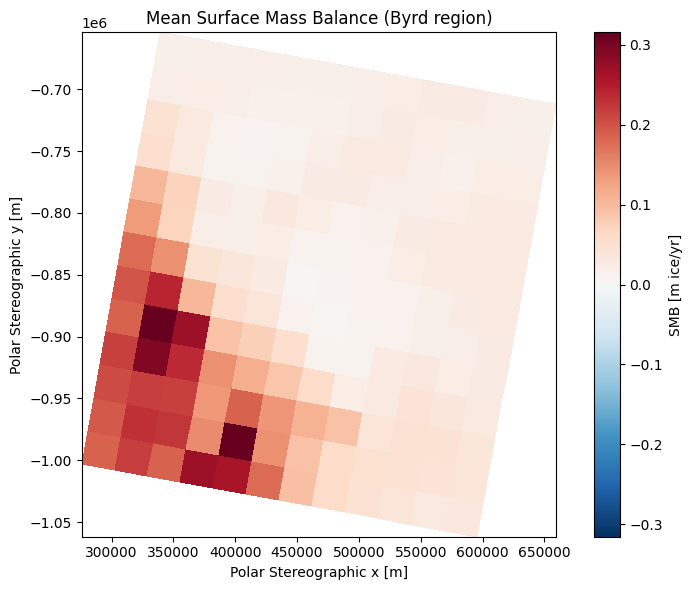

In [22]:
# Extract the data
smb = smb_byrd_ps["smb_yearly"]
x = smb_byrd_ps["x_ps"]
y = smb_byrd_ps["y_ps"]

# Determine symmetric color limits around zero
vmax = np.nanmax(np.abs(smb.values))
vmin = -vmax  # ensure diverging scale

# Plot
plt.figure(figsize=(8, 6))
pcm = plt.pcolormesh(
    x, y, smb,
    cmap = "RdBu_r",        # red-white-blue, reversed so red = positive, blue = negative
    vmin = vmin,
    vmax = vmax,
    shading = "auto"        # ensures pixel-aligned rendering
)
plt.colorbar(pcm, label = "SMB [m ice/yr]")
plt.title("Mean Surface Mass Balance (Byrd region)")
plt.xlabel("Polar Stereographic x [m]")
plt.ylabel("Polar Stereographic y [m]")
plt.gca().set_aspect('equal')
plt.tight_layout()
plt.show()

# Save as nc file

In [23]:
smb_byrd_ps.to_netcdf("data/racmo/smb_byrd_racmo24p1.nc")

# Interpolate grids over regions and retrieve average

In [64]:
data_locations_flat = np.column_stack(
    (smb_byrd_ps.x_ps.values.reshape(-1), smb_byrd_ps.y_ps.values.reshape(-1)))  # shape (N, 2)

data_values = smb_byrd_ps.smb_yearly.values.reshape(-1)  # shape (N,)

# --- Region data ---
regions = pd.read_csv("/home/kim/ice_thickness/data/real_data/corners_byrd_regions.csv")

for region in ["region_upper_byrd", "region_mid_byrd", "region_lower_byrd"]:
    x_min = regions[regions["name"] == region]["x_min"].item()
    x_max = regions[regions["name"] == region]["x_max"].item()
    y_min = regions[regions["name"] == region]["y_min"].item()
    y_max = regions[regions["name"] == region]["y_max"].item()

    print(f"{region} bounds: x_min = {x_min}, x_max = {x_max}, y_min = {y_min}, y_max = {y_max}")

    n_side = 20
    x_side = np.linspace(x_min, x_max, n_side)
    y_side = np.linspace(y_min, y_max, n_side)
    # Create a regular grid over the region
    x_grid, y_grid = np.meshgrid(x_side, y_side)

    target_locations_flat = np.column_stack((x_grid.reshape(-1), y_grid.reshape(-1)))  # shape (N, 2)

    smb_grid_interp = griddata(data_locations_flat, data_values, target_locations_flat, 
                        method = "cubic")

    mean_smb = np.mean(smb_grid_interp).item()
    print(
        f"The mean of the interpolated SMB in the {region} is: "
        f"{mean_smb:.4f} metre ice/yr ({mean_smb * 100:.1f} cm/yr)."
    )
    print()

region_upper_byrd bounds: x_min = 400000, x_max = 470000, y_min = -800000, y_max = -730000
The mean of the interpolated SMB in the region_upper_byrd is: 0.0168 metre ice/yr (1.7 cm/yr).

region_mid_byrd bounds: x_min = 395000, x_max = 465000, y_min = -870000, y_max = -800000
The mean of the interpolated SMB in the region_mid_byrd is: 0.0222 metre ice/yr (2.2 cm/yr).

region_lower_byrd bounds: x_min = 420000, x_max = 450000, y_min = -910000, y_max = -880000
The mean of the interpolated SMB in the region_lower_byrd is: 0.0477 metre ice/yr (4.8 cm/yr).

